In [8]:
import mitiq
from mitiq import benchmarks
import numpy as np
from cirq import DensityMatrixSimulator, depolarize
from mitiq.interface import convert_to_mitiq
from mitiq import zne
from mitiq import pec, rem
from mitiq import Executor
from mitiq.zne.scaling import fold_global, fold_gates_at_random, insert_id_layers
from mitiq.zne.inference import LinearFactory, RichardsonFactory

import matplotlib.pyplot as plt
from mitiq.benchmarks import generate_ghz_circuit
from mitiq.benchmarks import generate_rb_circuits
import warnings
import cirq

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
from cirq import DensityMatrixSimulator, amplitude_damp
from mitiq.interface import convert_to_mitiq
import numpy as np
from mitiq import ddd
from cirq import LineQubit, Circuit, rx, rz, CNOT, X, Y, Z, H, SWAP, DensityMatrixSimulator
from mitiq import MeasurementResult, Observable, PauliString, raw
import functools
from typing import List, Tuple
from cirq import DensityMatrixSimulator, depolarize
from functools import partial
from mitiq.raw import execute as raw_execute
from mitiq.rem import generate_inverse_confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

Here, Zero Noise extrapolation (ZNE), Probabilistic Error Cancellation (PEC), Digital Dynamical Decoupling (DDD), Readout Error Mitigation (REM) taken into consideration.

To understand better first these techniques applied individually and then we see the results of using stack techniques.
In this tutorial, for testing I have taken GHZ state for noise plot and randomized circuit for circuit depth plot.

Three types of noises we will use which are bit flip error, depolarize error, Amplitude damping error which were be defined in **"execute"** function.


In [4]:
# Different  noise model

def execute1(circuit, noise_level = 0.1):
    """ Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    executed with amplitude damping noise.
    """
    # Replace with code based on your frontend and backend.
    mitiq_circuit,_ = convert_to_mitiq(circuit)
    noisy_circuit = mitiq_circuit.with_noise(amplitude_damp(gamma = noise_level))
    rho = DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real

# Depolarizing
def execute2(circuit, noise_level):
    """Returns Tr[ρ |0><0|] where ρ is the state prepared by the circuit
    executed with depolarizing noise.
    """
    # Replace with code based on your frontend and backend
    mitiq_circuit,_ = convert_to_mitiq(circuit)
    noisy_circuit = mitiq_circuit.with_noise(depolarize(p= noise_level))
    rho = DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real

# Add depolarize only to two qubit gate

def execute3(circuit, noise_level = 0.1):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    executed with depolarizing noise acting on two-qubit gates.
    """
    # Replace with code based on youe frontend and backend.
    noisy_circuit = cirq.Circuit()
    for op in circuit.all_operations():
        noisy_circuit.append(op)
        # Add depolarizing noise after two-qubit gates
        if len(op.qubits) == 2:
            noisy_circuit.append(depolarize(p=noise_level, n_qubits=2)(*op.qubits))

    rho = DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real 



from functools import partial

import numpy as np
from cirq.experiments.single_qubit_readout_calibration_test import (
    NoisySingleQubitReadoutSampler,
)

from mitiq import MeasurementResult

def noisy_readout_executor(circuit, p0, p1, shots=8192) -> MeasurementResult:
    # Replace with code based on your frontend and backend.
    simulator = NoisySingleQubitReadoutSampler(p0, p1)
    result = simulator.run(circuit, repetitions=shots)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings, qubit_indices = (0, 1))


# ZNE

In [12]:
def execute(circuit, noise_level):
    """Returns Tr[ρ |0><0|] where ρ is the state prepared by the circuit
    executed with depolarizing noise.
    """
    # Replace with code based on your frontend and backend
    mitiq_circuit,_ = convert_to_mitiq(circuit)
    noisy_circuit = mitiq_circuit.with_noise(depolarize(p= noise_level))
    rho = DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real

In [5]:
frontend = "cirq"

In [6]:
circuit = benchmarks.generate_rb_circuits(
    n_qubits = 1, num_cliffords = 10, return_type = frontend,
)[0]

print(circuit)

0: ───Y^-0.5───X^0───X───Y^-0.5───Y^-0.5───X^0.5───Y^0.5───Y^-0.5───X^0───X───Y^0───X^0.5───Y^0───Y^-0.5───X^0.5───Y^-0.5───Y───X^0.5───Y^0.5───X^-0.5───Y^-0.5───X^0───Y───X^0───


In [20]:
from mitiq.zne.inference import LinearFactory

linear_fac = LinearFactory(scale_factors = [1.0, 2.0, 3]) 

poly_factory = zne.inference.PolyFactory(scale_factors = [1, 1.5, 2, 2.5, 3], order = 2)

exp_factory = zne.inference.ExpFactory(scale_factors = [1, 2, 3], asymptote = 0.5)

adaptive_factory = zne.inference.AdaExpFactory(steps = 5, asymptote = 0.5)

In [15]:

p = 0.1

true = []
Raw = []
ZNE_linear = []
ZNE_poly = []
ZNE_exp = []
ZNE_adapt = []

depth = np.linspace(1, 20, 20, dtype = int)

for d in depth:
    circuit = benchmarks.generate_rb_circuits(
    n_qubits = 1, num_cliffords = d, return_type = frontend,
    )[0]
    
    mitigated_result_linear = zne.execute_with_zne(circuit, lambda c: execute(c, noise_level = p), 
                                             scale_noise=fold_gates_at_random, factory = linear_fac)
    mitigated_result_poly = zne.execute_with_zne(circuit, lambda c: execute(c, noise_level = p), 
                                             scale_noise=fold_gates_at_random, factory = poly_factory)
    mitigated_result_exp = zne.execute_with_zne(circuit, lambda c: execute(c, noise_level = p), 
                                             scale_noise=fold_gates_at_random, factory = exp_factory)
    mitigated_result_adapt = zne.execute_with_zne(circuit, lambda c: execute(c, noise_level = p), 
                                             scale_noise=fold_gates_at_random, factory= adaptive_factory)
    
    true_result = zne.execute_with_zne(circuit, lambda c: execute(c, noise_level=0), 
                                        scale_noise=fold_gates_at_random)
    Raw_result = execute(circuit, noise_level=p)

    true.append(true_result)
    Raw.append(Raw_result)
    ZNE_linear.append(mitigated_result_linear)
    ZNE_poly.append(mitigated_result_poly)
    ZNE_exp.append(mitigated_result_exp)
    ZNE_adapt.append(mitigated_result_adapt)
    


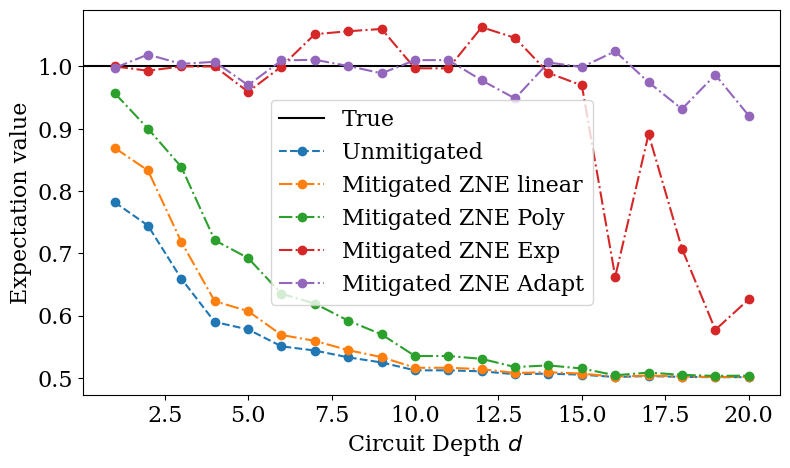

In [16]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 16})
plt.figure(figsize=(9, 5))

# Convert true to an array or use a single value
true_value = np.mean(true)  # or any other appropriate way to summarize true

plt.axhline(y=true_value, label="True", color="black")
plt.plot(depth, Raw, "--o", label="Unmitigated")
plt.plot(depth, ZNE_linear, "-.o", label="Mitigated ZNE linear")
plt.plot(depth, ZNE_poly, "-.o", label="Mitigated ZNE Poly")
plt.plot(depth, ZNE_exp, "-.o", label="Mitigated ZNE Exp")
plt.plot(depth, ZNE_adapt, "-.o", label="Mitigated ZNE Adapt")


plt.xlabel(" Circuit Depth $d$")
plt.ylabel(r"Expectation value")
plt.legend()
plt.show()


# DDD

In [17]:
import numpy as np
from cirq import DensityMatrixSimulator, amplitude_damp
from mitiq.interface import convert_to_mitiq

def execute(circuit,noise_level):
    """ Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    executed with amplitude damping noise.
    """
    # Replace with code based on your frontend and backend.
    mitiq_circuit,_ = convert_to_mitiq(circuit)
    noisy_circuit = mitiq_circuit.with_noise(amplitude_damp(gamma = noise_level))
    rho = DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real

In [22]:
long_rule = ddd.rules.xyxy
short_rule = ddd.rules.xx
circuit_with_xyxy = ddd.insert_ddd_sequences( circuit, rule = long_rule)
circuit_with_xyxy_and_xx = ddd.insert_ddd_sequences(circuit_with_xyxy, rule = short_rule)
circuit_with_xyxy_and_xx

0: ───H───@───I───X───X───
          │
1: ───────X───@───X───X───
              │
2: ───X───X───X───@───────
                  │
3: ───I───X───X───X───@───
                      │
4: ───X───Y───X───Y───X───

In [23]:

"""
rule = ddd.rules.yy
rule = ddd.rules.xx
long_rule = ddd.rules.xyxy
short_rule = ddd.rules.xx
Combine also...

"""
frontend = "cirq"
p = 0.1
#rule = ddd.rules.yy

true = []
Raw = []
DDD_yy = []
DDD_xx = []
DDD_xyxy = []
DDD_xyxy_and_xx = []


pvals = np.linspace(0, 0.3, 20)

for p in pvals:
    circuit = generate_ghz_circuit(5)
    
    mitigated_result_yy = ddd.execute_with_ddd(
    circuit = circuit,
    executor = lambda c: execute(c, noise_level = p),
    rule = ddd.rules.yy,)

    mitigated_result_xx = ddd.execute_with_ddd(
    circuit = circuit,
    executor = lambda c: execute(c, noise_level = p),
    rule = ddd.rules.xx,)

    mitigated_result_xyxy = ddd.execute_with_ddd(
    circuit = circuit,
    executor = lambda c: execute(c, noise_level = p),
    rule = ddd.rules.xyxy,)


    true_result = execute(circuit, noise_level = 0)
    Raw_result = execute(circuit, noise_level = p)
    mitigated_result_xyxy_and_xx = execute(circuit_with_xyxy_and_xx, noise_level = p)

    
    true.append(true_result)
    Raw.append(Raw_result)
    
    DDD_yy.append(mitigated_result_yy)
    DDD_xx.append(mitigated_result_xx)
    DDD_xyxy.append(mitigated_result_xyxy)
    DDD_xyxy_and_xx.append(mitigated_result_xyxy_and_xx)
    


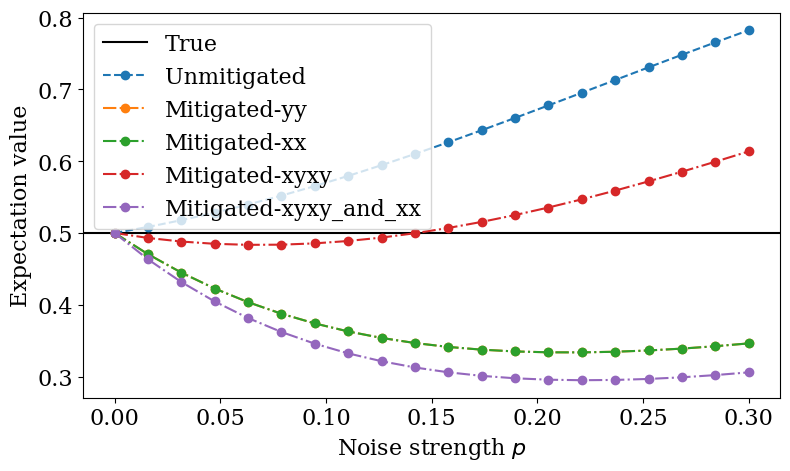

In [24]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 16})
plt.figure(figsize=(9, 5))

# Convert true to an array or use a single value
true_value = np.mean(true)  # or any other appropriate way to summarize true

plt.axhline(y=true_value, label="True", color="black")
plt.plot(pvals, Raw, "--o", label="Unmitigated")

plt.plot(pvals,DDD_yy, "-.o", label="Mitigated-yy")
plt.plot(pvals,DDD_xx, "-.o", label="Mitigated-xx")
plt.plot(pvals,DDD_xyxy, "-.o", label="Mitigated-xyxy")
plt.plot(pvals,DDD_xyxy_and_xx, "-.o", label="Mitigated-xyxy_and_xx")

plt.xlabel("Noise strength $p$")
plt.ylabel(r"Expectation value")
plt.legend()
plt.show()


# PEC

In [4]:
def execute(circuit, noise_level):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    executed with depolarizing noise.
    """
    # Replace with code based on your frontend and backend.
    mitiq_circuit, _ = convert_to_mitiq(circuit)
    # We add a simple noise model to simulate a noisy backend.
    noisy_circuit = mitiq_circuit.with_noise(depolarize(p=noise_level))
    rho = DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real

In [5]:
import mitiq
from mitiq import benchmarks

frontend = "cirq"  # Supported: "cirq", "qiskit", "pyquil", "braket", "pennylane".

circuit = benchmarks.generate_rb_circuits(
  n_qubits=1, num_cliffords=2, return_type = frontend,
)[0]
print(circuit)

0: ───Y^-0.5───X^-0.5───Y^-0.5───X^0───Y^0.5───X^0.5───Y^0.5───


In [30]:
# Compute the expectation value of the |0⟩⟨0| observable.
noisy_value = execute(circuit, noise_level = 0.01)
ideal_value = execute(circuit, noise_level=0.0)
print(f"Error without mitigation: {abs(ideal_value - noisy_value) :.5f}")

Error without mitigation: 0.04484


In [31]:
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise

noise_level = 0.01
reps = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level)

In [35]:
pec_value = pec.execute_with_pec(circuit,lambda c: execute(c, noise_level = 0.01), representations=reps)
pec_value

1.0030602078239865

In [6]:
import numpy as np
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise


depth = np.linspace(1, 20, 20, dtype=int)
noise_level = 0.1

for d in depth:
    circuit = benchmarks.generate_rb_circuits(
        n_qubits=1, num_cliffords=d, return_type=frontend
    )[0]

    ideal_value = execute(circuit, noise_level=0.0) 
    noisy_value = execute(circuit, noise_level=0.1)

    reps = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level)

    pec_executor = pec.mitigate_executor(lambda c: execute(c, noise_level=0.1), representations = reps)
    pec_result = pec_executor(circuit)

    print(ideal_value, noisy_value, pec_result.real)
    

1.0 0.7820841 0.981473524159436
1.0 0.6836265 0.9639062540979759


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 16})
plt.figure(figsize=(9, 5))

# Convert true to an array or use a single value
true_value = np.mean(true)  # or any other appropriate way to summarize true

plt.axhline(y=true_value, label="True", color="black")
plt.plot(depth, Raw, "--o", label="Unmitigated")

plt.plot(depth, pec, "-.o", label="Mitigated")


plt.xlabel("Noise strength $p$")
plt.ylabel(r"Expectation value")
plt.legend()
plt.show()


# REM

In [4]:
circuit = generate_rb_circuits(2, 10)[0]
# Argument:- num_qubit, num_cliffords ( The number of Clifford group elements 
                # in the random circuits. This is proportional to the depth per circuit. )
circuit

0: ───Y^-0.5───X^0─────@───Y^0.5───X^0.5────Y^-0.5───X^0.5───Y^0.5───@───X^0─────Y^0.5───X^0.5───@───X^-0.5───Y^-0.5───X^0.5───Y^-0.5───Y───────X^0─────@───Y^0.5───X^0.5───Y───────X^0.5───@───X^-0.5───Y^-0.5───X^0────────────@───Y^0.5────X^0.5────Y───────X^-0.5───@───Y^0.5────@───X^-0.5───Y^-0.5───X^0.5───X^0.5────Y^-0.5───@───X^0───Y───────X^0.5───────────────────@───Y^0.5───X^0.5───Y───────X^0.5───@───X^-0.5───Y^-0.5───
                       │                                             │                           │                                                      │                                   │                                    │                                      │            │                                               │                                         │                                   │
1: ───X^0.5────Y^0.5───@───Y^0.5───X^-0.5───Y^0──────────────────────@───Y^0.5───X───────Y^0─────@───Y────────X^0.5────X───────Y^0──────X^0.5───Y^0.5───@───Y───────X^0.5───X^0.5───Y^0─────@───Y────────X^0.5────Y^-0.5───X^0───@───X^-0.5───Y^-0.5───X^0.5───X^0──────@───X^-0.5───@───X^0.5────Y^0.5────X^0.5───Y^-0.5───X^0──────@───Y─────X^0.5───Y^0.5───X^0.5───Y^0.5───@───Y^0.5───X───────Y^0.5───────────@───Y^0.5─────────────

In [10]:
from functools import partial

import numpy as np
from cirq.experiments.single_qubit_readout_calibration_test import (
    NoisySingleQubitReadoutSampler,
)

from mitiq import MeasurementResult

def noisy_readout_executor(circuit, p0, p1, shots=8192) -> MeasurementResult:
    # Replace with code based on your frontend and backend.
    simulator = NoisySingleQubitReadoutSampler(p0, p1)
    result = simulator.run(circuit, repetitions=shots)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings, qubit_indices = (0, 1))

In [11]:
pvals = np.linspace(0, 0.3, 20)
pvals

array([0.        , 0.01578947, 0.03157895, 0.04736842, 0.06315789,
       0.07894737, 0.09473684, 0.11052632, 0.12631579, 0.14210526,
       0.15789474, 0.17368421, 0.18947368, 0.20526316, 0.22105263,
       0.23684211, 0.25263158, 0.26842105, 0.28421053, 0.3       ])

In [17]:
from mitiq import rem

observable = Observable(PauliString("ZI"), PauliString("IZ"))

true = []
raw = []
rec = []
pvals = np.linspace(0, 0.3, 20)
for p in pvals:
    circuit = generate_rb_circuits(2, 10)[0]

    p_flip = p

    noisy_executor = partial(noisy_readout_executor, p0=p_flip, p1=p_flip)
    noisy_value = raw_execute(circuit, noisy_executor, observable)

    ideal_executor = partial(noisy_readout_executor, p0=0, p1=0)
    ideal_value = raw_execute(circuit, ideal_executor, observable)

    inverse_confusion_matrix = generate_inverse_confusion_matrix(2, p_flip, p_flip)

    mitigated_result = rem.execute_with_rem(
    circuit,
    noisy_executor,
    observable,
    inverse_confusion_matrix=inverse_confusion_matrix,
)
    true.append(ideal_value.real)
    raw.append(noisy_value.real)
    rec.append(mitigated_result.real)
    
    

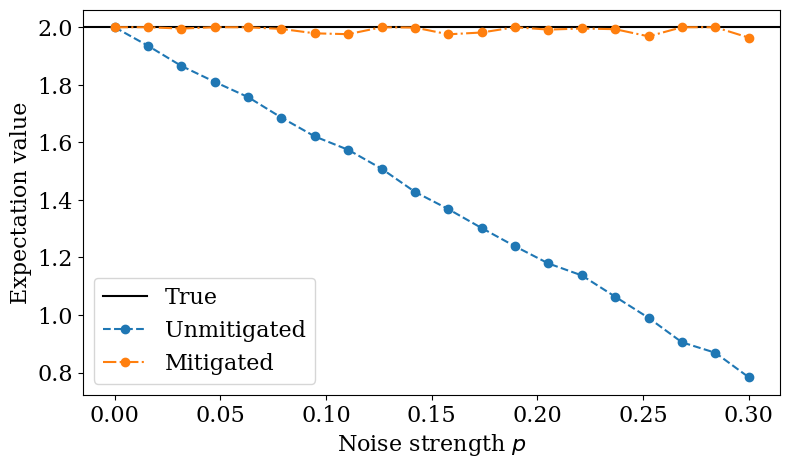

In [19]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 16})
plt.figure(figsize=(9, 5))

# Convert true to an array or use a single value
true_value = np.mean(true)  # or any other appropriate way to summarize true

plt.axhline(y = true_value, label="True", color="black")
plt.plot(pvals, raw, "--o", label="Unmitigated")

plt.plot(pvals, rec, "-.o", label="Mitigated")


plt.xlabel("Noise strength $p$")
plt.ylabel(r"Expectation value")
plt.legend()
plt.show()


# Stack techniques


## * ZNE & DDD
## * REC & ZNE

## * ZNE & DDD

In [20]:
def execute(circuit, noise_level, gamma):
    """Returns Tr[ρ |0><0|] where ρ is the state prepared by the circuit
    executed with depolarizing noise.
    """
    # Replace with code based on your frontend and backend
    mitiq_circuit,_ = convert_to_mitiq(circuit)
    noisy_circuit = mitiq_circuit.with_noise(depolarize(p= noise_level))
    noisy_circuit.append(mitiq_circuit.with_noise(amplitude_damp(gamma = gamma)))
    rho = DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real

# executor = Executor(execute)    

In [23]:
import numpy as np
"""
# Renamed arrays to avoid conflicts
ideal = []
noisy = []
ddd = []
zne = []
stack = []

"""

#depth = np.linspace(1, 20, 20, dtype=int)

pvals = np.linspace(0, 0.3, 20)
for p in pvals:
    circuit = generate_ghz_circuit(5)

    ddd_executor = ddd.mitigate_executor(lambda c: execute(c, noise_level= 0.1, gamma = p), rule=ddd.rules.yy)
    ddd_result = ddd_executor(circuit)

    zne_executor = zne.mitigate_executor(lambda c: execute(c, noise_level= 0.1, gamma = p), scale_noise=zne.scaling.folding.fold_global,
                                          factory=adaptive_factory)
    zne_result = zne_executor(circuit)

    combined_executor = zne.mitigate_executor(ddd_executor, scale_noise=zne.scaling.folding.fold_global,
                                              factory=adaptive_factory)
    combined_result = combined_executor(circuit)

    ideal_value = execute(circuit, noise_level= 0, gamma = 0) 
    noisy_value = execute(circuit, noise_level= 0.1, gamma = p)

    """
    ideal.append(ideal_value)
    noisy.append(noisy_value)
    ddd.append(ddd_result)
    zne.append(zne_result)
    stack.append(combined_result)
    """
    
    print(ddd_result, zne_result, combined_result, ideal_value, noisy_value)  # Print results


0.08673259615898132 0.08188794146333372 0.08188794146333372 0.24999997 0.086732596
0.090037502348423 0.07385902506347575 0.07831681399356466 0.24999997 0.09955983
0.09417706727981567 0.041830273608248814 0.07559488842496931 0.24999997 0.114230074
0.09915719926357269 -0.040509423965758296 0.07541431074577609 0.24999997 0.13078396
0.10496023297309875 0.10252013308956198 0.07838428895109578 0.24999997 0.14920922
0.11155097186565399 0.0834389724031806 0.0843751345650115 0.24999997 0.1694507
0.11888207495212555 0.05183075771046447 0.0928802998249687 0.24999997 0.1914191
0.1268979012966156 -0.004338326979498097 0.10328595672830043 0.24999997 0.21499783
0.13553819060325623 -0.11948735066440552 0.11502245199330519 0.24999997 0.24004945
0.1447402536869049 -0.5727476809195939 0.12762716805895435 0.24999997 0.26642075
0.15444086492061615 -0.9301141635871923 0.1407517738694971 0.24999997 0.2939474
0.164578378200531 0.29736767958693633 0.15414448679843923 0.24999997 0.3224575
0.1750933676958084 0.3

In [24]:
# Define arrays for each column
ddd_results = [0.08673259615898132, 0.090037502348423, 0.09417706727981567, 0.09915719926357269, 0.10496023297309875, 0.11155097186565399, 0.11888207495212555, 0.1268979012966156, 0.13553819060325623, 0.1447402536869049, 0.15444086492061615, 0.164578378200531, 0.1750933676958084, 0.1859297901391983, 0.19703537225723267, 0.20836295187473297, 0.21986933052539825, 0.23151664435863495, 0.24327236413955688, 0.2551085650920868]
zne_results = [0.08188794146333372, 0.07831681399356466, 0.07559488842496931, 0.07541431074577609, 0.07838428895109578, 0.0843751345650115, 0.0928802998249687, 0.10328595672830043, 0.11502245199330519, 0.12762716805895435, 0.1407517738694971, 0.15414448679843923, 0.16762829433337473, 0.18176358971856021, 0.19411391342021705, 0.20654411341456885, 0.2225277902574614, 0.2382144965567224, 0.2462116677528487, 0.25010175061878653]
combined_results = [0.086732596, 0.09955983, 0.114230074, 0.13078396, 0.14920922, 0.1694507, 0.1914191, 0.21499783, 0.24004945, 0.26642075, 0.2939474, 0.3224575, 0.35177502, 0.38172263, 0.41212335, 0.4428038, 0.47359386, 0.5043298, 0.5348552, 0.5650208]
ideal_values = [0.24999997] * 20
noisy_values = [0.086732596, 0.07385902506347575, 0.041830273608248814, -0.040509423965758296, 0.10252013308956198, 0.0834389724031806, 0.05183075771046447, -0.004338326979498097, -0.11948735066440552, -0.5727476809195939, -0.9301141635871923, 0.29736767958693633, 0.32774303741292365, 0.35897296307612736, 0.3909973585458914, 0.4239095750323162, 0.4584618281710086, 0.6901978733940286, 0.6694366647307786, 0.6798496823839089]

# Print the arrays
for i in range(20):
    print(ddd_results[i], zne_results[i], combined_results[i], ideal_values[i], noisy_values[i])  # Print results


0.08673259615898132 0.08188794146333372 0.086732596 0.24999997 0.086732596
0.090037502348423 0.07831681399356466 0.09955983 0.24999997 0.07385902506347575
0.09417706727981567 0.07559488842496931 0.114230074 0.24999997 0.041830273608248814
0.09915719926357269 0.07541431074577609 0.13078396 0.24999997 -0.040509423965758296
0.10496023297309875 0.07838428895109578 0.14920922 0.24999997 0.10252013308956198
0.11155097186565399 0.0843751345650115 0.1694507 0.24999997 0.0834389724031806
0.11888207495212555 0.0928802998249687 0.1914191 0.24999997 0.05183075771046447
0.1268979012966156 0.10328595672830043 0.21499783 0.24999997 -0.004338326979498097
0.13553819060325623 0.11502245199330519 0.24004945 0.24999997 -0.11948735066440552
0.1447402536869049 0.12762716805895435 0.26642075 0.24999997 -0.5727476809195939
0.15444086492061615 0.1407517738694971 0.2939474 0.24999997 -0.9301141635871923
0.164578378200531 0.15414448679843923 0.3224575 0.24999997 0.29736767958693633
0.1750933676958084 0.167628294

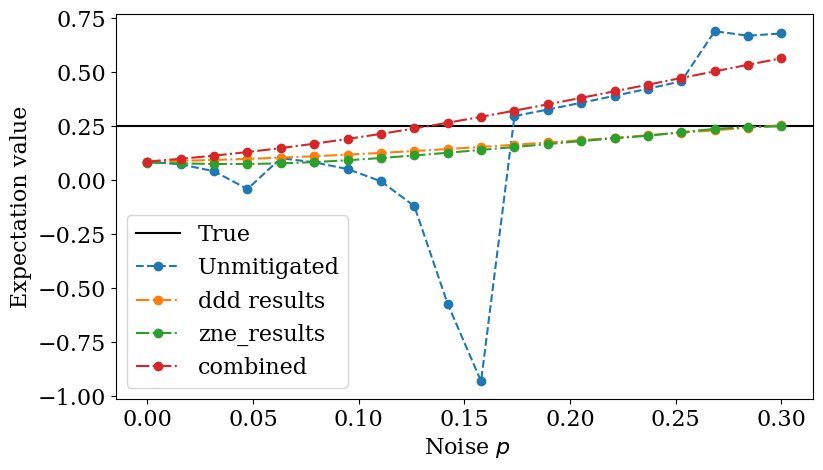

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({"font.family": "serif", "font.size": 16})
plt.figure(figsize=(9, 5))

# Convert true to an array or use a single value
true_value = np.mean(ideal_values)  # or any other appropriate way to summarize true

plt.axhline(y= true_value, label="True", color="black")
plt.plot(pvals, noisy_values, "--o", label="Unmitigated")

plt.plot(pvals, ddd_results, "-.o", label="ddd results")
plt.plot(pvals, zne_results, "-.o", label="zne_results")
plt.plot(pvals,combined_results, "-.o", label="combined")

plt.xlabel(" Noise $p$")
plt.ylabel(r"Expectation value")
plt.legend()
plt.show()


## * REC & ZNE

In [4]:
circuit = generate_rb_circuits(2, 10)[0]
# Argument:- num_qubit, num_cliffords ( The number of Clifford group elements 
                # in the random circuits. This is proportional to the depth per circuit. )
circuit

0: ───X─────Y^0.5───@───X^-0.5───Y^-0.5───Y^0.5───X^0.5───@───Y^0.5────@───Y────────X^0.5───X^0.5───Y^0.5───@───Y^0.5────@───Y^0.5────X───Y^-0.5───@───Y^0.5────@───X^-0.5───Y^-0.5───X^0.5───Y^-0.5───X^0.5───@───X^0───Y^0.5───X^0.5────────────@───Y^0.5────@───Y^0.5───Y───────X^-0.5────────────────────@───Y^0.5────@───X^-0.5───Y^-0.5───X^0.5───Y^0.5────X^0.5───@───X^0──────X^-0.5───Y^-0.5──────────────────@───Y^0.5────@───Y^0.5───Y^-0.5───X^0.5───Y^-0.5───────@───Y^0.5────@───Y^0.5───Y^-0.5───X^-0.5───────────────────────────@───Y^0.5───X^0.5───
                    │                                     │            │                                    │            │                         │            │                                              │                                  │            │                                             │            │                                              │                                             │            │                                         │            │                                                     │
1: ───X^0───────────@───Y────────X^0.5────X───────Y^0.5───@───X^-0.5───@───Y^-0.5───Y───────X^0─────────────@───X^-0.5───@───Y^-0.5───Y───X^-0.5───@───X^-0.5───@───Y^-0.5───Y^0.5────X^0.5───Y^0.5────────────@───Y─────X^0.5───Y^0.5───X^-0.5───@───X^-0.5───@───X^0.5───Y^0.5───X^0.5────X^-0.5───Y^0.5───@───X^-0.5───@───X^0.5────Y^0.5────X^0.5───X^-0.5───Y^0─────@───X^-0.5───Y^-0.5───X^0.5────X^-0.5───Y^0───@───X^-0.5───@───X^0.5───Y^0.5────X^0.5───Y────────X───@───X^-0.5───@───X^0.5───Y^0.5────X^0.5────Y^0.5───X^0.5───Y^0.5───@───Y^0.5───────────

In [16]:
def execute(circuit: cirq.Circuit, noise_level = 0.01, p0:float = 0.05)-> MeasurementResult:
    """ Execute a circuit with depolarizing noise of strength ""Noise_level"" and readout error
    """
    measurements = circuit[-1]
    circuit = circuit[:-1]
    circuit = circuit.with_noise(cirq.depolarize(noise_level))
    circuit.append(cirq.bit_flip(p0).on_each(circuit.all_qubits()))
    circuit.append(measurements)

    simulator = cirq.DensityMatrixSimulator()

    result = simulator.run(circuit, repetitions = 10000)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings)
    

In [6]:
obs = Observable(PauliString("ZI"), PauliString("IZ"))

In [26]:

p0 = p1 = 0.05

depth = np.linspace(1, 20, 20, dtype=int)
for d in depth:
    
    circuit = benchmarks.generate_rb_circuits(
      n_qubits= 2, num_cliffords= d, return_type = "cirq",
    )[0]

    ideal = raw.execute(circuit, partial(execute, noise_level = 0, p0 = 0), obs)
    noisy = raw.execute(circuit, execute, obs)
    
    icm = rem.generate_inverse_confusion_matrix(2, p0, p1)
    rem_executor = rem.mitigate_executor(execute, inverse_confusion_matrix = icm)
    rem_result = obs.expectation(circuit, rem_executor)

    zne_executor = zne.mitigate_executor(execute, observable= obs, scale_noise=zne.scaling.folding.fold_global)
    zne_result = zne_executor(circuit)

    combined_executor = zne.mitigate_executor(rem_executor, observable = obs,
                                          scale_noise = zne.scaling.folding.fold_global)
    combined_result = combined_executor(circuit)

    
    print(ideal.real, noisy.real, zne_result.real, rem_result.real, combined_result.real)

2.0 1.2962 1.8565999999999987 1.4508 2.143
2.0 1.3568 1.9082000000000001 1.5096 2.1986
2.0 1.0406 1.59 1.1442 1.7612000000000014
2.0 0.911 1.4932000000000005 1.0384 1.707400000000001
2.0 0.9274 1.6208000000000011 1.0548 1.8494000000000015
2.0 0.7012 1.5374000000000017 0.7558 1.5656000000000023
2.0 0.6716 1.2594000000000014 0.7136 1.532600000000002
2.0 0.5446 1.1314000000000017 0.6026 1.2420000000000015
2.0 0.4478 1.0172000000000017 0.482 1.1204000000000012
2.0 0.5962000000000001 1.3074000000000014 0.6672 1.4844000000000022
2.0 0.4304 1.0218000000000016 0.4538 1.1524000000000019
2.0 0.3798 0.9772000000000016 0.40080000000000005 0.9958000000000015
2.0 0.2986 0.7576000000000014 0.3104 0.8082000000000018
2.0 0.3726 0.9144000000000012 0.37739999999999996 1.0008000000000015
2.0 0.1752 0.4910000000000009 0.13 0.2952000000000004
2.0 0.21139999999999998 0.556000000000001 0.21300000000000002 0.4320000000000005
2.0 0.2072 0.5500000000000012 0.2128 0.5564000000000009
2.0 0.09259999999999999 0.2136

In [27]:
# Define the values
ideal_values = [2.0] * 20
noisy_values = [1.2962, 1.3568, 1.0406, 0.911, 0.9274, 0.7012, 0.6716, 0.5446, 0.4478, 0.5962, 0.4304, 0.3798, 0.2986, 0.3726, 0.1752, 0.2114, 0.2072, 0.0926, 0.1158, 0.137]
zne_results = [1.8566, 1.9082, 1.59, 1.4932, 1.6208, 1.5374, 1.2594, 1.1314, 1.0172, 1.3074, 1.0218, 0.9772, 0.7576, 0.9144, 0.491, 0.556, 0.55, 0.2136, 0.4554, 0.399]
rem_results = [1.4508, 1.5096, 1.1442, 1.0384, 1.0548, 0.7558, 0.7136, 0.6026, 0.482, 0.6672, 0.4538, 0.4008, 0.3104, 0.3774, 0.13, 0.213, 0.2128, 0.0966, 0.1628, 0.128]
combined_results = [2.143, 2.1986, 1.7612, 1.7074, 1.8494, 1.5656, 1.5326, 1.242, 1.1204, 1.4844, 1.1524, 0.9958, 0.8082, 1.0008, 0.2952, 0.432, 0.5564, 0.2302, 0.4642, 0.2762]


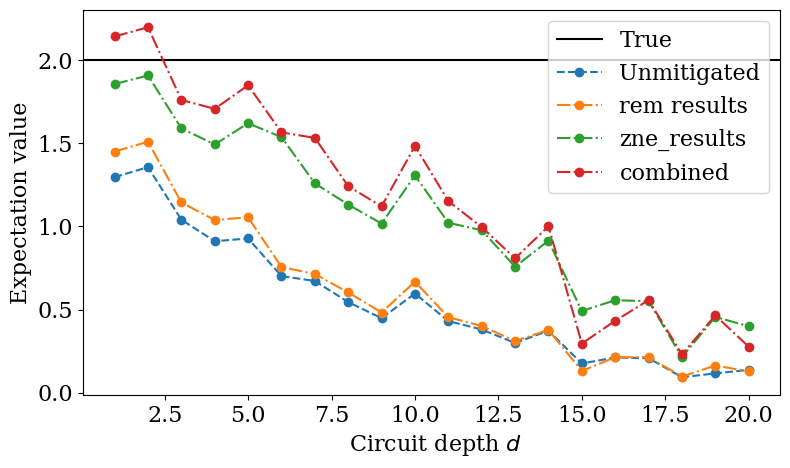

In [28]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({"font.family": "serif", "font.size": 16})
plt.figure(figsize=(9, 5))

# Convert true to an array or use a single value
true_value = np.mean(ideal_values)  # or any other appropriate way to summarize true

plt.axhline(y = true_value, label="True", color="black")
plt.plot( depth, noisy_values, "--o", label="Unmitigated")

plt.plot(depth, rem_results, "-.o", label="rem results")
plt.plot(depth, zne_results, "-.o", label="zne_results")
plt.plot(depth,combined_results, "-.o", label="combined")

plt.xlabel(" Circuit depth $d$")
plt.ylabel(r"Expectation value")
plt.legend()
plt.show()
